# Mobile phone localization

<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

___

<br>

Your mobile phone is constantly trying to keep track of where you are. At any given point in time, for all nearby locations, your phone stores a probability that you are in that location.

<br>

<center>
<img src="https://jonghank.github.io/ase3001/files/Conventional-method-of-cell-phone-localization.png" width="600">
</center>

<br>

Right now your phone believes that you are in one of the $100\times 100$ discretized grid cells with some probabilities. Those probabilities are given in $P^{\text{prior}}\in\R^{100\times 100}$, where $P^{\text{prior}}_{ij}$ is the probability that you are at $(i,j)$-th discretized cell. The matrix is shown below.


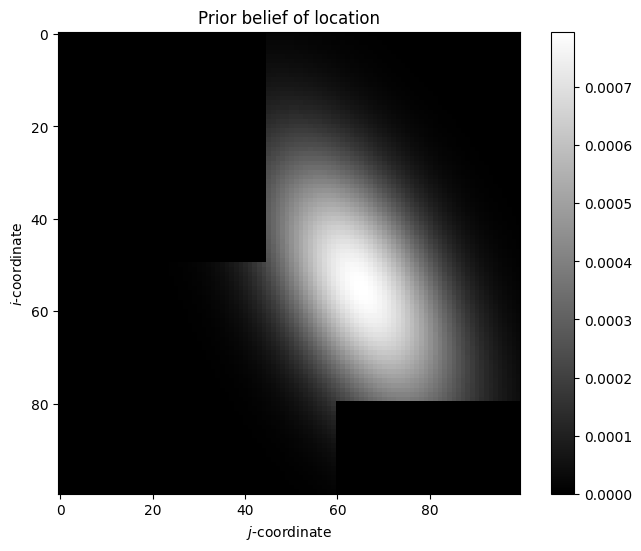

In [111]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
P_prior = np.zeros((N,N))

x_j = np.arange(N)
x_i = x_j

W = np.array([[200, 150], [150, 400]])*2
inv_W = np.linalg.inv(W)
b = np.array([65, 55])

for i in range(N):
  for j in range(N):
    x = [x_j[j], x_i[i]]
    P_prior[i,j] = np.exp(-(x-b).T@inv_W@(x-b))

P_prior[:50,:45] = 0
P_prior[80:,60:] = 0
P_prior /= np.sum(P_prior)

plt.figure(figsize=(8,6), dpi=100)
plt.imshow(P_prior, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Prior belief of location')
plt.show()

<br>

___

<br>

Small questions:

<br>

_**(Problem 1)**_
What is the sum of all the probabilities, $\sum_{i,j}P_{ij}$?


In [112]:
# your code here
sum = 0
for i in range(N) : 
    for j in range(N) :
        sum += P_prior[i,j] 

print(f'{sum}')


0.9999999999999963


<br>

So in the picture, the white locations (with large $P^\text{prior}_{ij}$) are where you probably are , and the dark locations (with small $P^\text{prior}_{ij}$) are where you are not likely to be. If someone asks for the user's position _now_, you will want to find the position with highest $P^\text{prior}_{ij}$.


<br>

_**(Problem 2)**_ What is the location at which the user is most likely to be?

In [113]:
# your code here
max_idx = np.unravel_index(np.argmax(P_prior), P_prior.shape)
print(max_idx)

(np.int64(55), np.int64(65))


<br>

___

<br>

Now your phone connects to some known base towers and records two bars of signal. For each grid location $(i,j)$, you know the probability of observing two bars from this particular tower, given that the mobile phone is in location $(i,j)$. That is, you know $P(\text{observe two bar} \mid \text{you are at} (i,j))$. We denote this probability by $P^\text{observe2}_{ij}$, and the matrix $P^\text{observe2}$ is shown below. Note that this value is based on knowledge of the dynamics of this particular base tower and stochasticity of signal strength.

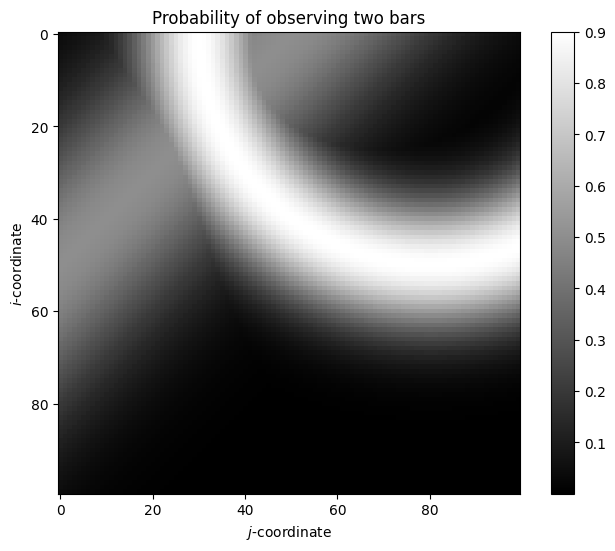

In [114]:
P_observe2 = np.zeros((N,N))

for i in range(N):
  for j in range(N):
    dist1 = np.linalg.norm([x_j[j]-80, x_i[i]-0])
    prob1 = np.exp(-(dist1-50)**2/200)*0.9
    dist2 = (x_j[j]+x_i[i])
    prob2 = np.exp(-(dist2-50)**2/1000)*0.5
    P_observe2[i,j] = np.max([prob1, prob2])

plt.figure(figsize=(8,6), dpi=100)
plt.imshow(P_observe2, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Probability of observing two bars')
plt.show()

<br>

_**(Problem 3)**_
For each of the 10000 location positions, calculate and plot the new probability that the user is in each location given the base tower observation (the two bar observation). Recall the Bayes' theorem giving

<br>

\begin{align*}
  P\left(\text{being at } (i,j) \ \vert\ \text{observing two bars}\right)
  &= \frac{P\left(\text{observing two bars} \ \vert\ \text{being at } (i,j) \right)\,P(\text{being at }(i,j))}{P(\text{observing two bars})}\\
  &= \frac{P(\text{observing two bars} \ \vert\ \text{being at } (i,j) )\,P(\text{being at }(i,j))}{\sum_{k,l}P(\text{observing two bars} \ \vert\ \text{being at } (k,l) )\,P(\text{being at }(k,l))}\\
\end{align*}

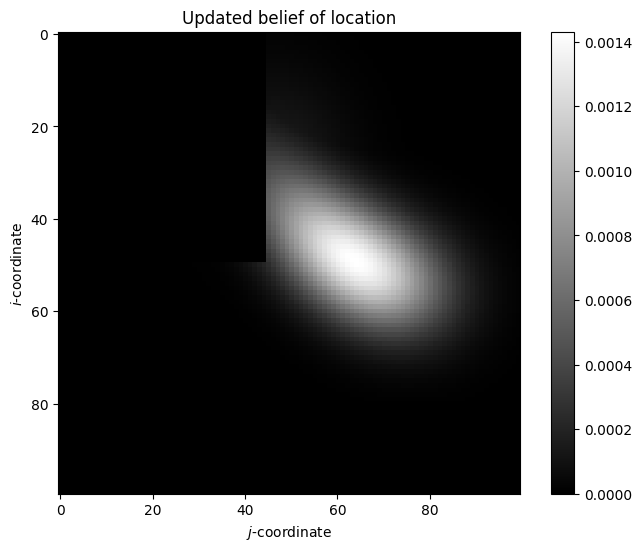

In [115]:
# your code here
P_Antenna2 = np.sum(P_prior*P_observe2)
P_prior_observe2 = P_observe2*P_prior/(P_Antenna2)

plt.figure(figsize=(8,6), dpi=100)
plt.imshow(P_prior_observe2, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Updated belief of location')
plt.show()


<br>

_**(Problem 4)**_
Now someone _again_ asks for the user's position. What is your updated answer?


In [116]:
# your code here
new_max_idx = np.unravel_index(np.argmax(P_prior_observe2), P_prior_observe2.shape)
print(new_max_idx)

(np.int64(49), np.int64(64))


<br>

_**(Problem 5)**_
Suppose you observe two bars from the same base station *again*, after the initial two-bar observation. This is an independent observation. Given the initial prior belief and the two independent observations of two bars from the same base station, what is the updated probability that the user is in each location? Plot the resulting probability distribution.

You should use the posterior probability distribution calculated after the first two-bar observation as the new prior for this second two-bar observation.

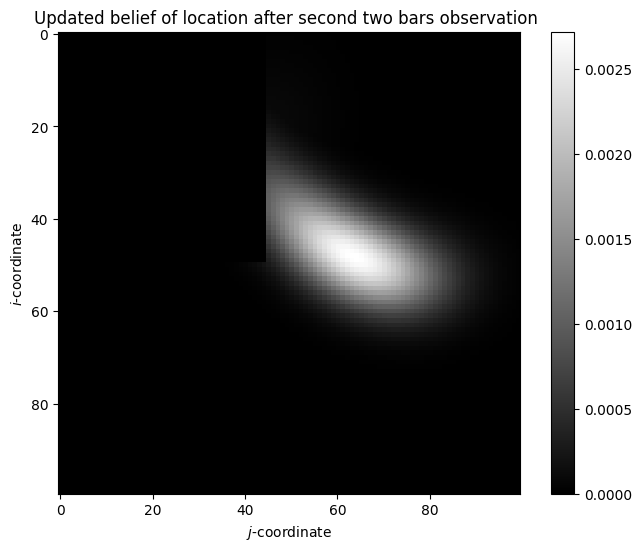

In [117]:
# your code here
P_Antenna2_update = np.sum(P_prior_observe2*P_observe2)
P_prior_observe2_update = P_observe2*P_prior_observe2/(P_Antenna2)

plt.figure(figsize=(8,6), dpi=100)
plt.imshow(P_prior_observe2_update, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Updated belief of location after second two bars observation ')
plt.show()

<br>

_**(Problem 6)**_
Now someone _again_ asks for the user's position. What is your updated answer?


In [118]:
# your code here
new_max_idx_2 = np.unravel_index(np.argmax(P_prior_observe2_update), P_prior_observe2_update.shape)
print(new_max_idx_2)

(np.int64(48), np.int64(63))


_**(add problem)**_ 관측 횟수가 증가함에 따라 어디로 수렴하는지 plot하기 

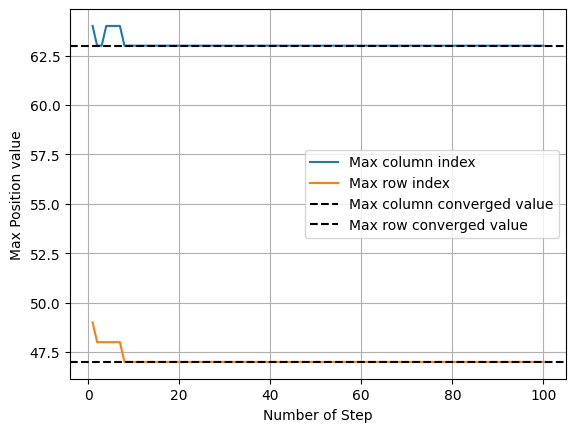

[np.int64(49), np.int64(48), np.int64(48), np.int64(48), np.int64(48), np.int64(48), np.int64(48), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.int64(47), np.in

In [123]:
N = 100
P_prior = np.zeros((N,N))

x_j = np.arange(N)
x_i = x_j

W = np.array([[200, 150], [150, 400]])*2
inv_W = np.linalg.inv(W)
b = np.array([65, 55])

for i in range(N):
  for j in range(N):
    x = [x_j[j], x_i[i]]
    P_prior[i,j] = np.exp(-(x-b).T@inv_W@(x-b))

P_prior[:50,:45] = 0
P_prior[80:,60:] = 0
P_prior /= np.sum(P_prior)

P_observe2 = np.zeros((N,N))

for i in range(N):
  for j in range(N):
    dist1 = np.linalg.norm([x_j[j]-80, x_i[i]-0])
    prob1 = np.exp(-(dist1-50)**2/200)*0.9
    dist2 = (x_j[j]+x_i[i])
    prob2 = np.exp(-(dist2-50)**2/1000)*0.5
    P_observe2[i,j] = np.max([prob1, prob2])

step = 100
update_max_row = []
update_max_col = []

for i in range(1,step+1) :
  P_Antenna = np.sum(P_prior*P_observe2)
  P_prior_observe2_update_repeat = P_prior*P_observe2/P_Antenna
  update_max_row.append(np.argmax(P_prior_observe2_update_repeat)//N)
  update_max_col.append(np.argmax(P_prior_observe2_update_repeat)%N)
  P_prior = P_prior_observe2_update_repeat

plt.plot(range(1,step+1), update_max_col, label = 'Max column index ')
plt.plot(range(1,step+1), update_max_row, label = 'Max row index')
plt.axhline(update_max_col[-1], linestyle = '--', label = 'Max column converged value', color ='black')
plt.axhline(update_max_row[-1], linestyle = '--', label = 'Max row converged value', color = 'black')
plt.grid(True)
plt.legend()
plt.xlabel("Number of Step")
plt.ylabel("Max Position value")
plt.show()
#반복을 증가시킴에 따라 특정 위치로 수렴한다.
print(update_max_row)

* * *

<br>

Now, a moment after observing two bars, you check your phone again and observe *three* bars from the same base station. Similar to the two-bar observation, we have a probability matrix $P^\text{observe3}$, where $P^\text{observe3}_{ij}$ is the probability of observing three bars given that you are at location $(i,j)$.

<br>

***(Problem 7)***
Given the initial prior belief, the observation of two bars, and then the subsequent independent observation of three bars from the same base station, what is the updated probability that the user is in each location? Plot the resulting probability distribution.

You should use the posterior probability distribution calculated after the two-bar observation as the new prior for this three-bar observation.

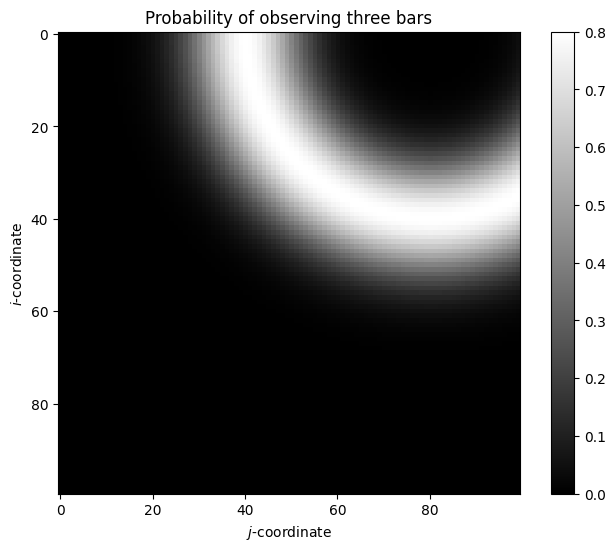

In [120]:
# The probability of observing three bars given the location.
P_observe3 = np.zeros((N,N))

for i in range(N):
  for j in range(N):
    dist = np.linalg.norm([x_j[j]-80, x_i[i]-0]) # Same base station location as before
    # Probability function for observing 3 bars
    P_observe3[i,j] = np.exp(-(dist-40)**2/150)*0.8

plt.figure(figsize=(8,6), dpi=100)
plt.imshow(P_observe3, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Probability of observing three bars')
plt.show()


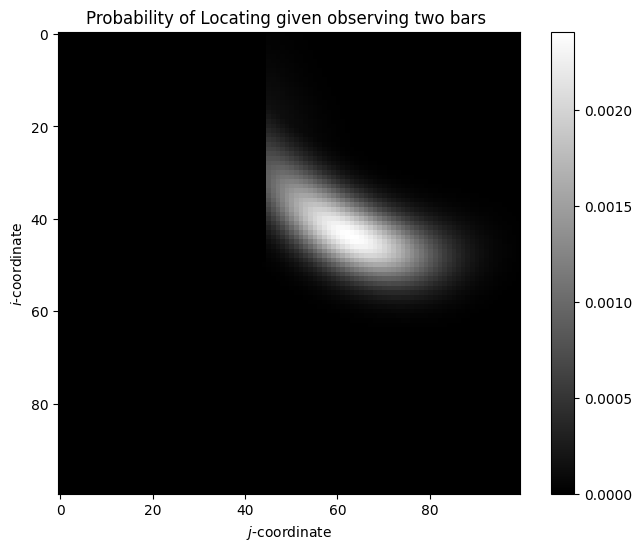

In [121]:
# your code here
P_Antenna3 = np.sum(P_prior_observe2_update*P_observe3)
P_prior_observe3 = P_observe3*P_prior_observe2_update/(P_Antenna3)

plt.figure(figsize=(8,6), dpi=100)
plt.imshow(P_prior_observe3, cmap='gray')
plt.colorbar()
plt.xlabel(r'$j$-coordinate')
plt.ylabel(r'$i$-coordinate')
plt.title('Probability of Locating given observing two bars ')
plt.show()

<br>

_**(Problem 8)**_
Now someone _again_ asks for the user's position. What is your updated answer?


In [122]:
# your code here
new_max_idx_3bar = np.unravel_index(np.argmax(P_prior_observe3), P_prior_observe3.shape)
print(new_max_idx_3bar)

(np.int64(44), np.int64(63))
